In [ ]:
#@title Load Swirl-LM from Git
!git clone https://github.com/google-research/swirl-lm.git
!./swirl-lm/swirl_lm/setup.sh
!python3 -m pip show swirl-lm

In [10]:
#@title Imports
import functools
import sys
import time

from absl import flags
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from swirl_lm.base import driver
from swirl_lm.base import driver_tpu
from swirl_lm.base import initializer
from swirl_lm.base import parameters
from swirl_lm.utility import get_kernel_fn
from swirl_lm.utility import tpu_util
from swirl_lm.utility import types

FlowFieldMap = types.FlowFieldMap

flags.FLAGS(sys.argv[:1])

['/export/hda3/Google internallet/remote_hdd_fs_dirs/0.wqing_colab_kernel_viperlite_pod_126387097.1.kernel.wqing.280917313810.14b334fb3717c109/mount/server/notebook.par']

In [2]:
# @title Simulation parameters.
PARAMS_PBTXT = """
    solver_procedure: VARIABLE_DENSITY
    convection_scheme: CONVECTION_SCHEME_QUICK
    time_integration_scheme: TIME_SCHEME_CN_EXPLICIT_ITERATION
    grid_params {
      # The number of cores in 3 dimensions.
      computation_shape {
        dim_0: 1
        dim_1: 1
        dim_2: 8
      }
      # The physical size of the simulation domain in units of m.
      length {
        dim_0: 6.28318530718
        dim_1: 6.28318530718
        dim_2: 6.28318530718
      }
      # The number of grid points per core in 3 dimensions including ghost cells
      # (halos).
      grid_size {
        dim_0: 128
        dim_1: 128
        dim_2: 20
      }
      # The width of the ghost cells on each side of the domain. It is set to 2
      # considering the stencil width of the QUICK scheme.
      halo_width: 2
      # The time step size in units of s.
      dt: 0.01
      # The size of the convolution kernel to be used for fundamental numerical
      # operations.
      kernel_size: 16
      periodic {
        dim_0: true dim_1: true dim_2: true
      }
    }
    pressure {
      solver {
        jacobi {
          max_iterations: 10
          halo_width: 2
          omega: 0.67
        }
      }
    }
    density: 1.0
    kinematic_viscosity: 6.25e-4
    use_sgs: false
"""

params = parameters.SwirlLMParameters.config_from_text_proto(
    PARAMS_PBTXT, grid_params_from_flags=False
)

In [3]:
# @title Initial conditions
U_MAG = 1.0  # The magnitude of the velocity component.
RHO_REF = 1.0  # Reference density used in pressure-induced Taylor-Green vortex.
P_REF = 0.0  # Reference pressure used in pressure-induced Taylor-Green vortex.
FIELDS = ('u', 'v', 'w', 'p')  # Keys for flow field variable.


def taylor_green_vortices(
    replica_id: tf.Tensor,
    coordinates: initializer.ThreeIntTuple,
    params: parameters.SwirlLMParameters,
) -> FlowFieldMap:
  """Initialize the u, v, w, and p field in each TPU replica.

  The velocity and pressure fields are initialized following the reference:

  J. R. DeBonis, Solutions of the Taylor-Green vortex problem using
  high-resolution explicit finite difference methods, 51st AIAA Aerospace
  Sciences Meeting including the New Horizons Forum and Aerospace Exposition,
  2013.

  Args:
    replica_id: The ID number of the replica.
    coordinates: A tuple that specifies the replica's grid coordinates in
      physical space.

  Returns:
    A dictionary of states and values that are stored as string and 3D tensor
    pairs.
  """

  v0 = U_MAG
  p0 = P_REF
  rho0 = RHO_REF

  def get_vortices(state_key):
    """Generates the vortex field for each flow variable."""

    def get_u(
        xx,
        yy,
        zz,
        lx,
        ly,
        lz,
        coord,
    ):
      """Generates the velocity component in dim 0.

      Args:
        xx: The sub-mesh in dimension 0 in the present replica.
        yy: The sub-mesh in dimension 1 in the present replica.
        zz: The sub-mesh in dimension 2 in the present replica.
        lx: Length in dimension 0.
        ly: Length in dimension 1.
        lz: Length in dimension 2.
        coord: The coordinate of the local core.

      Returns:
        The 3D velocity field in dimension 0 in the present replica.
      """
      del coord
      x_corr = params.dx / (lx + params.dx) * 2.0 * np.pi
      y_corr = params.dy / (ly + params.dy) * 2.0 * np.pi
      z_corr = params.dz / (lz + params.dz) * 2.0 * np.pi
      return (
          v0
          * tf.math.sin((2.0 * np.pi - x_corr) * xx / lx)
          * tf.math.cos((2.0 * np.pi - y_corr) * yy / ly)
          * tf.math.cos((2.0 * np.pi - z_corr) * zz / lz)
      )

    def get_v(
        xx,
        yy,
        zz,
        lx,
        ly,
        lz,
        coord,
    ):
      """Generates the velocity component in dim 1.

      Args:
        xx: The sub-mesh in dimension 0 in the present replica.
        yy: The sub-mesh in dimension 1 in the present replica.
        zz: The sub-mesh in dimension 2 in the present replica.
        lx: Length in dimension 0.
        ly: Length in dimension 1.
        lz: Length in dimension 2.
        coord: The coordinate of the local core.

      Returns:
        The 3D velocity field in dimension 1 in the present replica.
      """
      del coord
      x_corr = params.dx / (lx + params.dx) * 2.0 * np.pi
      y_corr = params.dy / (ly + params.dy) * 2.0 * np.pi
      z_corr = params.dz / (lz + params.dz) * 2.0 * np.pi
      return (
          -v0
          * tf.math.cos((2.0 * np.pi - x_corr) * xx / lx)
          * tf.math.sin((2.0 * np.pi - y_corr) * yy / ly)
          * tf.math.cos((2.0 * np.pi - z_corr) * zz / lz)
      )

    def get_w(
        xx,
        yy,
        zz,
        lx,
        ly,
        lz,
        coord,
    ):
      """Generates the velocity component in dim 2.

      Args:
        xx: The sub-mesh in dimension 0 in the present replica.
        yy: Not used.
        zz: Not used.
        lx: Not used.
        ly: Not used.
        lz: Not used.
        coord: The coordinate of the local core.

      Returns:
        The 3D velocity field in dimension 2 in the present replica.
      """
      del yy, zz, lx, ly, lz, coord
      return tf.zeros_like(xx, dtype=xx.dtype)

    def get_p(
        xx,
        yy,
        zz,
        lx,
        ly,
        lz,
        coord,
    ):
      """Generates the pressure field.

      Args:
        xx: The sub-mesh in dimension 0 in the present replica.
        yy: The sub-mesh in dimension 1 in the present replica.
        zz: The sub-mesh in dimension 2 in the present replica.
        lx: Length in dimension 0.
        ly: Length in dimension 1.
        lz: Length in dimension 2.
        coord: The coordinate of the local core.

      Returns:
        The 3D pressure field in the present replica.
      """
      del coord
      x_corr = params.dx / (lx + params.dx) * 2.0 * np.pi
      y_corr = params.dy / (ly + params.dy) * 2.0 * np.pi
      z_corr = params.dz / (lz + params.dz) * 2.0 * np.pi
      return p0 + rho0 * v0**2 / 16.0 * (
          (tf.math.cos(2.0 * (2.0 * np.pi - z_corr) * zz / lz) + 2.0)
          * (
              tf.math.cos(2.0 * (2.0 * np.pi - x_corr) * xx / lx)
              + tf.math.cos(2.0 * (2.0 * np.pi - y_corr) * yy / ly)
          )
      )

    if state_key == 'u':
      return get_u
    elif state_key == 'v':
      return get_v
    elif state_key == 'w':
      return get_w
    elif state_key == 'p':
      return get_p
    else:
      raise ValueError(
          'State key must be one of u, v, w, p. {} is given.'.format(state_key)
      )

  output = {'replica_id': replica_id}
  for key in FIELDS:
    output.update({
        key: initializer.partial_mesh_for_core(
            params, coordinates, get_vortices(key)
        )
    })

  if params.solver_procedure == parameters.SolverProcedure.VARIABLE_DENSITY:
    output.update({'rho': tf.ones_like(output['u'], dtype=output['u'].dtype)})

  return output

In [4]:
#@title Initializes the TPU strategy.
computation_shape = np.array([params.cx, params.cy, params.cz])

try:
  # TPU detection.
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime.')

tf.config.experimental_connect_to_cluster(tpu)
topology = tf.tpu.experimental.initialize_tpu_system(tpu)
device_assignment, _ = tpu_util.tpu_device_assignment(
      computation_shape=computation_shape, tpu_topology=topology)
tpu_strategy = tf.distribute.experimental.TPUStrategy(
    tpu, device_assignment=device_assignment)
logical_coordinates = tpu_util.grid_coordinates(computation_shape).tolist()

print('All devices: ', tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [5]:
# @title Utility functions for postprocessing.


def merge_result(values, coordinates, halo_width):
  """Merges results from multiple TPU replicas following the topology."""
  if len(values) != len(coordinates):
    raise (
        ValueError,
        (
            'The length of `value` and `coordinates` must equal. Now `values`'
            f' has length {len(values)}, but `coordinates` has length'
            f' {len(coordinates)}.'
        ),
    )

  # The results are oriented in order z-x-y.
  nz, nx, ny = values[0].shape
  nz_0, nx_0, ny_0 = [n - 2 * halo_width for n in (nz, nx, ny)]

  # The topology is oriented in order x-y-z.
  cx, cy, cz = np.array(np.max(coordinates, axis=0)) + 1

  # Compute the total size without ghost cells/halos.
  shape = [n * c for n, c in zip([nz_0, nx_0, ny_0], [cz, cx, cy])]

  result = np.empty(shape, dtype=np.float32)

  for replica in range(len(coordinates)):
    s = np.roll(
        [c * n for c, n in zip(coordinates[replica], (nx_0, ny_0, nz_0))],
        shift=1,
    )
    e = [s_i + n for s_i, n in zip(s, (nz_0, nx_0, ny_0))]
    result[s[0] : e[0], s[1] : e[1], s[2] : e[2]] = values[replica][
        halo_width : nz_0 + halo_width,
        halo_width : nx_0 + halo_width,
        halo_width : ny_0 + halo_width,
    ]

  return result


def get_np_array(state, varname, computation_shape, coordinates, halo_width):
  """Get numpy array of a particular variable"""
  if np.prod(computation_shape) == 1:
    result = state[varname].numpy()[
        params.halo_width : -params.halo_width,
        params.halo_width : -params.halo_width,
        params.halo_width : -params.halo_width,
    ]
  else:
    result = merge_result(
        state[varname].values, logical_coordinates, halo_width
    )
  return result


nx = (params.nx - 2 * params.halo_width) * params.cx
ny = (params.ny - 2 * params.halo_width) * params.cy
nz = (params.nz - 2 * params.halo_width) * params.cz

x = np.linspace(0.0, params.lx, nx)
y = np.linspace(0.0, params.ly, ny)
z = np.linspace(0.0, params.lz, nz)

## Run the simulation

In [6]:
# @title Initializes the simulation.
state = driver_tpu.distribute_values(
    tpu_strategy,
    value_fn=functools.partial(taylor_green_vortices, params=params),
    logical_coordinates=logical_coordinates,
)

In [11]:
num_steps = 100
num_cycles = 10

kernel_op = get_kernel_fn.ApplyKernelConvOp(params.kernel_size)
model = driver._get_model(kernel_op, params)

for cycle in range(num_cycles):
  tic = time.time()
  state, completed_steps = driver._one_cycle(
      strategy=tpu_strategy,
      init_state=state,
      init_step_id=tf.constant(cycle * num_steps),
      num_steps=num_steps,
      params=params,
      model=model,
  )
  print(f'Cycle: {cycle}, Run time: {time.time()-tic: .2f} Seconds')

Cycle: 0, Run time:  26.38 Seconds
Cycle: 1, Run time:  1.70 Seconds
Cycle: 2, Run time:  0.77 Seconds
Cycle: 3, Run time:  0.76 Seconds
Cycle: 4, Run time:  0.76 Seconds
Cycle: 5, Run time:  0.77 Seconds
Cycle: 6, Run time:  0.77 Seconds
Cycle: 7, Run time:  0.76 Seconds
Cycle: 8, Run time:  0.77 Seconds
Cycle: 9, Run time:  0.77 Seconds


JIT compilation of the TensorFlow graph is performed when a function is called for the first few times. Hence, first few cycles can take a long time (1-4 minutes per cycle in this case). The compiled graph is then used for subsequent calls to the same function with the same input type in the later cycles. The actual runtime for every cycle of 100 steps in this example is ~4 seconds with TPUv3.


Text(0.5, 1.0, 'Y Velocity')

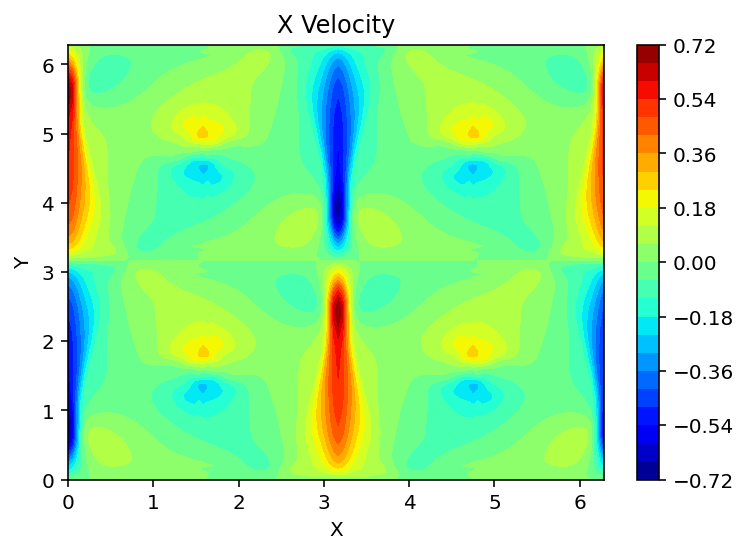

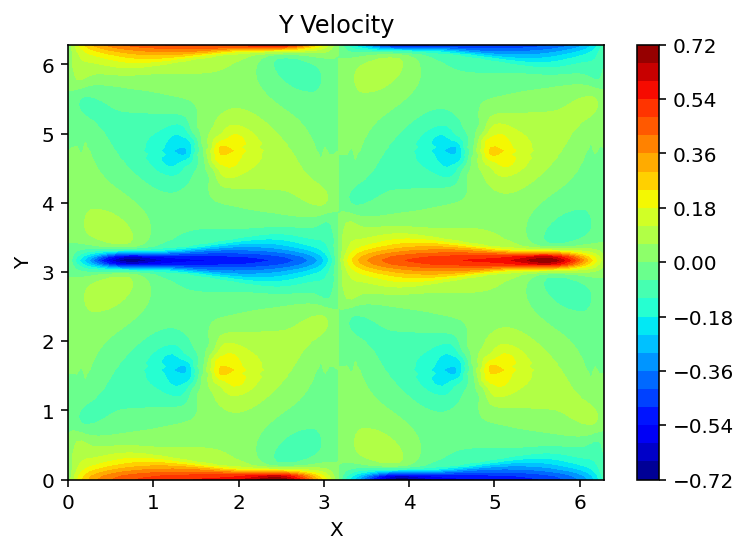

In [12]:
u = get_np_array(
    state, 'u', computation_shape, logical_coordinates, params.halo_width
)
v = get_np_array(
    state, 'v', computation_shape, logical_coordinates, params.halo_width
)
plt.figure()
plt.contourf(x, y, u[nz // 2, :, :], levels=25, cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('X Velocity')

plt.figure()
plt.contourf(x, y, v[nz // 2, :, :], levels=25, cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Y Velocity')

Text(0.5, 1.0, 'Streamlines Colored by Speed')

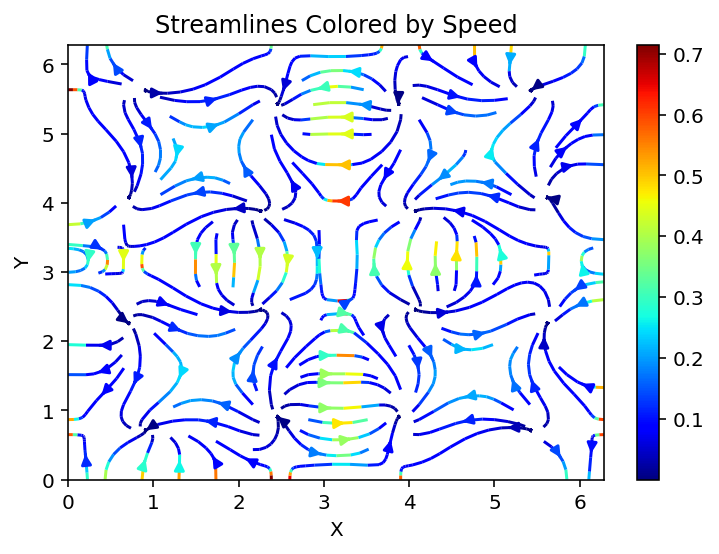

In [13]:
speed = np.sqrt(u**2 + v**2)
plt.figure()
strm = plt.streamplot(
    x,
    y,
    u[nz // 2, :, :],
    v[nz // 2, :, :],
    color=speed[nz // 2, :, :],
    cmap=plt.cm.jet,
)
plt.colorbar(strm.lines)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Streamlines Colored by Speed')